# Median gene lengths across all viruses with known hosts


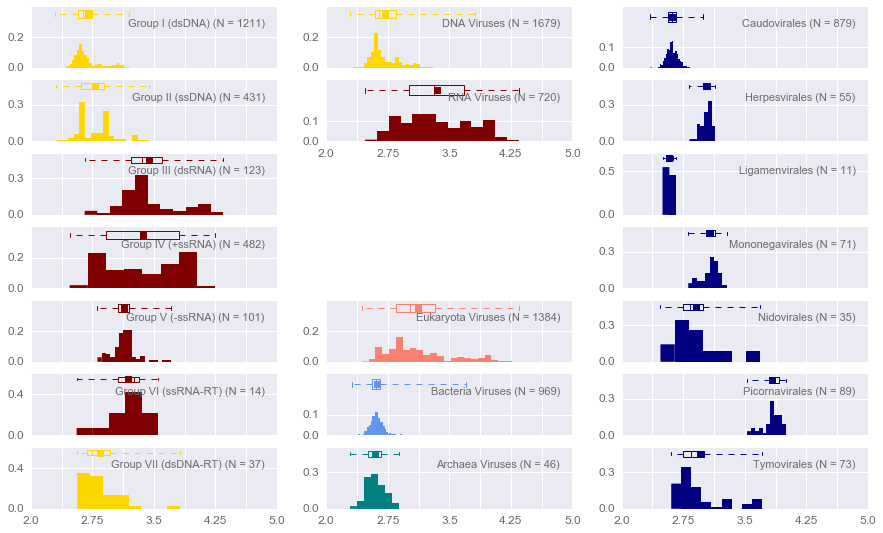

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import ete3 as ete
import os
import Bio
import random
import scipy.stats as stats
from functools import *
from Bio import Entrez
from Bio import SeqIO
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

#filename that will be the name of both the stat text file and the plot. 
filename = 'geneLengthHistograms'
inputFileNameTXT = filename + '.txt'
fo = open(inputFileNameTXT, 'w')
#writing the first line here, and the rest as part of the for loop 
fo.write('\t'+'Gene Length Statistics For Different Viral Groups (no. of bases)'+'\n')
fo.write('\t'+ 'Min' +'\t'+ 'Max' + '\t'+ '25th Percentile'+'\t'+ 'Median'+ '\t' + '75th Percentile' +'\t' +
         'Mean' + '\t' +'Stdev.' +'\t'+ 'Min (Log10)' +'\t'+ 'Max (Log10)' + '\t'+ '25th percentile (Log10)'+'\t
         '+ 'Median (Log10)'+ '\t' + '75th percentile (Log10)' +'\t' + 'Mean (Log10)' + '\t' +'Stdev. (Log10)' +'\n')

#as part of quality control the following viruses had to be omitted from our analysis
#they contain various types of misannotations or mislabeled hosts 
badFolders = ['Acyrthosiphon_pisum_secondary_endosymbiont_phage_1_uid14047', 'Aureococcus_anophagefferens_virus_MM_2014_uid258005', 'Dragonfly_associated_microphage_1_uid177547', 'Enterobacter_phage_PG7_uid240014', 'Escherichia_phage_vB_EcoM_JS09_uid248321', 'Lactobacillus_phage_LL_H_uid19803', 'Providencia_phage_Redjac_uid177540', 'Pseudoalteromonas_phage_RIO_1_uid206039', 'Sputnik_virophage_2_uid243067', 'Sputnik_virophage_3_uid243065', 'Staphylococcus_phage_6ec_uid253318', 'Streptococcus_phage_DCC1738_uid253219', 'Streptococcus_phage_IC1_uid253220', 'Streptococcus_phage_K13_uid253223', 'Streptococcus_phage_SMP_uid18529', 'Vibrio_phage_CP_T1_uid181062', 'Vibrio_phage_vpms1_uid212709', 'Vibrio_phage_VPUSM_8_uid227006',  'Abaca_bunchy_top_virus_uid28697','Shallot_yellow_stripe_virus_uid15745','Equine_rhinitis_A_virus_uid15205','African_pouched_rat_arterivirus_uid274797','Spilanthes_yellow_vein_virus_uid19779', 'Velvet_bean_severe_mosaic_virus_uid41175','Paramecium_bursaria_Chlorella_virus_FR483_uid18305','Human_endogenous_retrovirus_K113_uid222261','Acholeplasma_phage_MV_L1_uid14573']
#Another group of vviruses with misannotations, this time in their taxonomy (they don't belong to any Baltimore group)
unknowns= ['Bacillus_phage_phBC6A51_uid15021', 'Bacillus_phage_phBC6A52_uid15022', 'Badger_feces_associated_gemycircularvirus_uid281125', 'Chaetoceros_DNA_virus_7_uid237558', 'Chaetoceros_lorenzianus_DNA_Virus_uid63565', 'Chaetoceros_tenuissimus_DNA_virus_uid60753', 'Cladosporium_cladosporioides_virus_1_uid258308', 'Enterobacteria_phage_YYZ_2008_uid32231', 'European_mountain_ash_ringspot_associated_virus_uid39973', 'Faecal_associated_gemycircularvirus_3_uid268557', 'Faecal_associated_gemycircularvirus_4_uid268556', 'Faecal_associated_gemycircularvirus_5_uid268555', 'Faecal_associated_gemycircularvirus_6_uid268554', 'Faecal_associated_gemycircularvirus_7_uid268553', 'Gentian_ovary_ring_spot_virus_uid256090', 'Geobacillus_virus_E2_uid19797', 'Glossina_pallidipes_salivary_gland_hypertrophy_virus_uid28839', 'Haloarcula_hispanica_icosahedral_virus_2_uid109269', 'Haloarcula_phage_SH1_uid15535', 'Halovirus_PH1_uid196975', 'Halovirus_VNH_1_uid262927', 'Human_genital_associated_circular_DNA_virus_1_uid281399', 'Lactobacillus_johnsonii_prophage_Lj771_uid28145', 'Magnaporthe_oryzae_RNA_virus_uid272442', 'Mongoose_feces_associated_gemycircularvirus_a_uid281407', 'Mongoose_feces_associated_gemycircularvirus_b_uid281406', 'Mongoose_feces_associated_gemycircularvirus_c_uid281404', 'Mongoose_feces_associated_gemycircularvirus_d_uid281405', 'Mycoplasma_phage_phiMFV1_uid14387', 'Penicillium_roqueforti_dsRNA_mycovirus_1_uid258162', 'Phage_Gifsy_1_uid32269', 'Phage_Gifsy_2_uid32271', 'Pigeonpea_cryptic_virus_uid244664', 'Planaria_asexual_strain_specific_virus_like_element_type_1_uid14140', 'Pseudomonas_phage_phi_Pto_bp6g_uid240724', 'Rhizoctonia_fumigata_mycovirus_uid283068', 'Rhodococcus_phage_REQ2_uid81171', 'Rhodococcus_phage_REQ3_uid81175', 'Rose_rosette_virus_uid64937', 'Rosellinia_necatrix_fusarivirus_1_uid255787', 'Rosellinia_necatrix_megabirnavirus_1_W779_uid41609', 'Salisaeta_icosahedral_phage_1_uid167575', 'Salmonella_phage_Fels_1_uid29267', 'Sodalis_phage_phiSG1_uid16583', 'Staphylococcus_phage_phi2958PVL_uid32173', 'Staphylococcus_phage_tp310_1_uid20659', 'Staphylococcus_phage_tp310_3_uid20663', 'Stenotrophomonas_phage_phiSMA9_uid15493', 'Streptococcus_phage_20617_uid239271', 'Streptococcus_phage_phiBHN167_uid227353', 'Streptococcus_pyogenes_phage_315_1_uid14533', 'Streptococcus_pyogenes_phage_315_2_uid14528', 'Streptococcus_pyogenes_phage_315_3_uid14529', 'Streptococcus_pyogenes_phage_315_4_uid14530', 'Streptococcus_pyogenes_phage_315_5_uid14531', 'Streptococcus_pyogenes_phage_315_6_uid14532', 'Tanay_virus_uid246129', 'Thermococcus_prieurii_virus_1_uid84407', 'Thermus_phage_IN93_uid14235', 'Thermus_phage_P23_77_uid40235']
badFolders=badFolders+unknowns
#these are satellite viruses, which we will exclude from further analysis in this manuscript 
sats = ['Ageratum_conyzoides_associated_symptomless_alphasatellite_uid259293', 'Ageratum_enation_alphasatellite_uid181994', 'Ageratum_leaf_curl_betasatellite_uid195929', 'Ageratum_leaf_curl_Cameroon_betasatellite_uid36669', 'Ageratum_yellow_leaf_curl_betasatellite_uid14439', 'Ageratum_yellow_vein_China_alphasatellite_uid237561', 'Ageratum_yellow_vein_China_virus_associated_DNA_beta_uid15515', 'Ageratum_yellow_vein_Singapore_alphasatellite_uid14232', 'Ageratum_yellow_vein_virus_satellite_DNA_beta_uid14444', 'Alternanthera_yellow_vein_virus_satellite_DNA_beta_uid19833', 'Andrographis_yellow_vein_leaf_curl_betasatellite_uid243492', 'Bhendi_yellow_vein_India_betasatellite__India_Aurangabad_OY164_2006__uid61557', 'Bhendi_yellow_vein_mosaic_betasatellite__India_Coimbator_OYCO1_2005__uid61777', 'Bhendi_yellow_vein_mosaic_virus_associated_alphasatellite_uid174781', 'Bhendi_yellow_vein_mosaic_virus_satellite_DNA_beta_uid14445', 'Black_medic_leafroll_alphasatellite_1_uid243500', 'Cardamom_bushy_dwarf_virus_satellite_uid230064', 'Cassava_mosaic_Madagascar_alphasatellite_uid175666', 'Chili_leaf_curl_Bhatinda_betasatellite_uid206467', 'Chilli_leaf_curl_alphasatellite_uid253224', 'Chilli_leaf_curl_Multan_alphasatellite_uid39933', 'Chilli_leaf_curl_virus_satellite_DNA_beta_uid14441', 'Cleome_leaf_crumple_virus_associated_DNA_1_uid60045', 'Corchorus_yellow_vein_mosaic_betasatellite_uid192608', 'Cotton_leaf_curl_Burewala_alphasatellite_uid45935', 'Cotton_leaf_curl_Burewala_betasatellite_uid45933', 'Cotton_leaf_curl_Gezira_alphasatellite_uid42507', 'Cotton_leaf_curl_Gezira_virus_satellite_DNA_beta_uid15166', 'Cotton_leaf_curl_Multan_betasatellite_uid15780', 'Cotton_leaf_curl_virus_associated_DNA_1_isolate_Lucknow_uid65305', 'Cotton_leaf_curl_virus_associated_DNA_beta_uid14438', 'Cotton_leaf_curl_virus_betasatellite_uid162497', 'Cowpea_severe_leaf_curl_associated_DNA_beta_uid15157', 'Croton_yellow_vein_mosaic_alphasatellite_uid45931', 'Croton_yellow_vein_mosaic_betasatellite_uid18249', 'Cuban_alphasatellite_1_uid210798', 'Dragonfly_associated_alphasatellite_uid181244', 'Emilia_yellow_vein_virus_associated_DNA_beta_uid37893', 'Erectites_yellow_mosaic_virus_satellite_DNA_beta_uid19827', 'Eupatorium_yellow_vein_virus_satellite_DNA_beta_uid14447', 'Faba_bean_necrotic_stunt_alphasatellite_1_uid243499', 'Faba_bean_necrotic_stunt_alphasatellite_2_uid243498', 'French_bean_leaf_curl_betasatellite_Kanpur_uid169556', 'Gossypium_darwinii_symptomless_alphasatellite_uid39593', 'Gossypium_davidsonii_symptomless_alphasatellite_uid39589', 'Gossypium_mustilinum_symptomless_alphasatellite_uid39591', 'Grapevine_satellite_virus_uid208539', 'Guar_leaf_curl_alphasatellite_uid193981', 'Hedyotis_uncinella_yellow_mosaic_betasatellite_uid230991', 'Honeysuckle_yellow_vein_mosaic_disease_associated_satellite_DNA_beta_uid19863', 'Honeysuckle_yellow_vein_mosaic_virus_satellite_DNA_beta_uid14620', 'Leucas_zeylanica_yellow_vein_virus_satellite_DNA_beta_uid41305', 'Ludwigia_leaf_distortion_betasatellite__India_Amadalavalasa_Hibiscus_2007__uid29233', 'Ludwigia_yellow_vein_virus_associated_DNA_beta_uid15561', 'Luffa_puckering_and_leaf_distortion_associated_betasatellite__India_Gurdaspur_Okra_2013__uid253218', 'Luffa_puckering_and_leaf_distortion_associated_DNA_beta_uid15779', 'Malachra_yellow_vein_mosaic_virus_associated_satellite_DNA_beta_uid28727', 'Malvastrum_leaf_curl_betasatellite_uid16301', 'Malvastrum_leaf_curl_Guangdong_betasatellite_uid243827', 'Malvastrum_yellow_vein_Yunnan_virus_satellite_DNA_beta_uid14567', 'Melon_chlorotic_mosaic_virus_associated_alphasatellite_uid51413', 'Mesta_yellow_vein_mosaic_virus_alphasatellite__India_Hoshiarpur_Okra_2013__uid253217', 'Mesta_yellow_vein_mosaic_virus_associated_alphasatellite_uid174780', 'Mesta_yellow_vein_mosaic_virus_associated_DNA_beta_uid21015', 'Milk_vetch_dwarf_C10_alphasatellite_uid240682', 'Mirabilis_leaf_curl_India_virus_associated_betasatellite_uid255800', 'Mungbean_yellow_mosaic_India_virus_associated_betasatellite__India__Faizabad__Cow_Pea_2012__uid177773', 'Nanovirus_like_particle_uid14386', 'Okra_enation_leaf_curl_betasatellite__India_Sonipat_EL10_2006__uid61781', 'Okra_leaf_curl_Mali_virus_satellite_DNA_beta_uid20323', 'Okra_yellow_vein_disease_associated_sequence_uid14443', 'Olive_viral_satellite_RNA_uid230268', 'Papaya_leaf_curl_alphasatellite_uid233414', 'Papaya_leaf_curl_China_virus_satellite_DNA_beta_uid19819', 'Pepper_leaf_curl_virus_satellite_DNA_beta_uid28283', 'Pepper_leaf_curl_Yunnan_virus_satellite_DNA_beta_uid29415', 'Potato_apical_leaf_curl_disease_associated_satellite_DNA_beta_uid18323', 'Radish_leaf_curl_virus_betasatellite_uid28281', 'Sida_leaf_curl_virus_satellite_DNA_beta_uid19823', 'Sida_yellow_mosaic_virus_China_associated_DNA_beta_uid15514', 'Sida_yellow_vein_China_alphasatellite_uid238950', 'Siegesbeckia_yellow_vein_virus_associated_DNA_beta_uid17269', 'Subterranean_clover_stunt_C6_alphasatellite_uid14180', 'Synedrella_leaf_curl_alphasatellite_uid263034', 'Tobacco_leaf_chlorosis_betasatellite_uid178075', 'Tobacco_leaf_curl_disease_associated_sequence_uid14442', 'Tobacco_leaf_curl_PUSA_alphasatellite_uid56023', 'Tobacco_leaf_curl_virus_associated_DNA_beta_uid45925', 'Tomato_leaf_curl_Bangladesh_betasatellite_uid56017', 'Tomato_leaf_curl_Gandhinagar_betasatellite_uid231683', 'Tomato_leaf_curl_Hajipur_betasatellite_uid175587', 'Tomato_leaf_curl_Joydebpur_virus_satellite_DNA_beta_uid28273', 'Tomato_leaf_curl_Karnataka_alphasatellite_uid181995', 'Tomato_leaf_curl_Pakistan_virus_associated_DNA_1_uid38463', 'Tomato_leaf_curl_Patna_betasatellite_uid36541', 'Tomato_leaf_curl_Togo_betasatellite_Togo_2006__uid60629', 'Tomato_leaf_curl_Yemen_betasatellite_uid177643', 'Tomato_yellow_leaf_curl_China_betasatellite_uid181248', 'Tomato_yellow_leaf_curl_Vietnam_virus_satellite_DNA_beta_uid19829', 'TYLCCNV_Y322__satellite_DNA_beta_uid16338', 'Vernonia_yellow_vein_betasatellite_uid41303', 'Vernonia_yellow_vein_Fujian_virus_alphasatellite_uid72145', 'Vernonia_yellow_vein_Fujian_virus_betasatellite_uid72143', 'Zinnia_leaf_curl_disease_associated_sequence_uid14440', 'Zinnia_leaf_curl_virus_associated_DNA_beta_uid14538']


def getTaxidFromGenomeFolder(genome_folder):    
    #This will take an rpt file for a genome and return the taxid in it.     
    if folder not in badFolders and folder not in sats:
        with open(os.path.join('all_rpt', folder, os.listdir(os.path.join('all_rpt', folder))[0])) as rpt_file:
            for line in rpt_file:
                if line.startswith('Taxid: '):
                    return int(line[7:-1])
                

def getHostTaxidFromGenomeFolder(genome_folder):
    #Takes a folder containing an asn file and returns the taxid of the host of the virus described by that asn file.
    if folder not in badFolders and folder not in sats:
        with open('folderToHostTaxid.txt', 'r') as taxid2host:
            for line in taxid2host:
                if genome_folder in line:
                    return int(line.split('\t')[1][:-1])
        return 0
    

def getGenomeLengthFromGenomeFolder(genome_folder):
    total = 0
    #reads genome length from ptt files
    if folder not in badFolders and folder not in sats:
        for file in os.listdir(os.path.join('all_ptt', folder)):
            with open(os.path.join('all_ptt', folder, file)) as ptt_file:
                line = ptt_file.readline()
                index = line.find('- 1..')
                if index == -1:
                    return -1
                num = line[index + 5 : -1]
                total += int(num)
        return total
   

def getNumPolyProteinsFromGenomeFolder(genome_folder):
    polyCount = 0
    excluded =[]
    for file in os.listdir(os.path.join('all_ptt', folder)):
        #these folders contain genomes with misannotation of in non-coding DNA, or host information from NCBI. 
        if folder not in badFolders and folder not in sats:
            with open(os.path.join('all_ptt', folder, file)) as ptt_file:
                line = ptt_file.readline()
                line = ptt_file.readline()
                line = ptt_file.readline()                
                for line in ptt_file:
                    if any(s in line for s in excluded):
                        polyCount += 1                
    return polyCount
    

def getCodingNumberAndOverlapNumberFromGenomeFolder(folder):
    totalCoding = 0
    totalOverlap = 0
    for file in os.listdir(os.path.join('all_ptt', folder)):
        #these folders contain genomes with misannotation of gene overlap, non-coding DNA, or host information from NCBI. 
        if folder not in badFolders and folder not in sats:
            with open(os.path.join('all_ptt', folder, file)) as ptt_file:
                line = ptt_file.readline()
                index = line.find('- 1..')
                repliconLength = int(line[index + 5 : -1])
                indicesThatOverlap = [0] * repliconLength
                line = ptt_file.readline()
                line = ptt_file.readline()

                uniqueIndices = set([])
                for line in ptt_file:
                    line = line.split('\t')[0]
                    [start, end] = [int(x) for x in line.split('..')]
                    #this is put in place to distinguish linear from circular genomes. Here, we're looking for linear genomes
                    if start < end:                    
                        for i in range(start, end):
                            if i in uniqueIndices:
                                indicesThatOverlap[i] = 1
                            else:
                                uniqueIndices.add(i)
                    #here were are looking for circular genomes to be able to properly count noncoding bases
                    elif start > end:
                        for i in range(start, repliconLength):
                            if i in uniqueIndices:
                                indicesThatOverlap[i] = 1
                            else:
                                uniqueIndices.add(i)
                        for i in range(1, end):
                            if i in uniqueIndices:
                                indicesThatOverlap[i] = 1
                            else:
                                uniqueIndices.add(i)
                           
                totalCoding += len(uniqueIndices)
                #totalOverlap += len(bigList) - len(uniqueIndices)
                totalOverlap += sum(indicesThatOverlap)
    return (totalCoding, totalOverlap)


def makePlot(virusGroups, hostNames, plotPositionVert):
    #plotPositionVert will let the program know where in the 7x3 subplots to place the figures that are generated. 
    #medProtLengthByGroup is a list of lists containing length of median gene length per virus group across 
    #different classifications (originally we were interested in protein length, hence the variable name). 
    medProtLengthByGroup = [[(np.log10(x['median']*3)) for x in group] for group in virusGroups]
    #yVec is normalized frequency. Basically 1/N, where N is the number of viruses per viral group. 
    #Note, median multiplied by 3 to reflect the median gene length.  
    yVec = [len([x['median']*3 for x in group]) for group in virusGroups]     
    
    #boxWidth is the width of the box plot
    boxWidth = 0.05 
    #matOfOnes will be a list of lists, containing ones. It has the same structure as medProtLengthByGroup
    matOfOnes=[]
    #matWeight will hold 1/N values. 
    matWeight=[]
    #ylimitVec will hold max histogram bar height, so the plot y limit can be determined based off of it. 
    
    counter = range(len(yVec))
    #per each classification system, we're looping through viral groups, which correspond to j. 
    for j in counter:
        vecOfOnes= np.zeros(yVec[j]) + 1.
        matOfOnes.append(vecOfOnes)
        matWeight.append([k / yVec[j] for k in vecOfOnes])   
        
        #we want to make sure that the nucleotide classification plots end up at the 15th and 18th subplot positions
        if plotPositionVert is 4:
            if j is 0:
                plotPositionHor = 14
            elif j is 1: 
                plotPositionHor = 17
            else:
                plotPositionHor = 20
            ax1 = plt.subplot(7,3, plotPositionHor)       
        #all other subplots are placed automatically according to their plotPositionVert, 
        #which is specified later in the code
        else:
            plotPositionHor = 3*j + plotPositionVert
            ax1 = plt.subplot(7,3, plotPositionHor)
        
        #calculating the number of bins needed according to Freedman-Diaconis rule. 
        #Bin width = 2 * IQR * N^(-1/3), where N is number of datapoints, IQR is interquartile range. 
        #number of bins can be calculated from bin width according to bin number = (max(data) - min(data))/bin width
        iqr=np.percentile(medProtLengthByGroup[j], 75, interpolation='higher') - np.percentile(medProtLengthByGroup[j],
                                                                                               25, interpolation='lower')
        bottom = binWidth=2*iqr*len(medProtLengthByGroup[j])**(-1/3)
        top = max(medProtLengthByGroup[j])-min(medProtLengthByGroup[j])
        binNumFreed =int(np.ceil(top/bottom))
        
        #plotting the normalized histograms, and ensuring bins of equal length by setting 'bins' equal
        #to an array with equal spacings
        n, bins, patches = plt.hist(medProtLengthByGroup[j], weights=matWeight[j], bins=binNumFreed, color=colors[j], linewidth=0)
        maxHeight= np.round(np.amax(n),1) + 0.2
        
        #instead of a legend, since there is only one figure per plot, I'm annotating the plot with virus 
        #group name, and number of viruses per that group 
        ax1.annotate(hostNames[j] + ' (N = ' + str(yVec[j]) + ')', xy=(0.95, 0.8), xycoords='axes fraction',
                horizontalalignment='right', verticalalignment='top', fontsize=11, color='dimgrey')   
        
        #drawing the boxplots. 
        bp = plt.boxplot(medProtLengthByGroup[j], showmeans=True, sym='', widths=boxWidth, vert=False, 
                         boxprops=dict(color=colors[j]),positions=[maxHeight-0.05],
                         capprops=dict(markerfacecolor=colors[j]),medianprops=dict(color=colors[j]), 
                         meanprops=dict(markerfacecolor=colors[j]), whis='range')        
        plt.setp(bp['whiskers'], color=colors[j])
        plt.setp(bp['caps'], color=colors[j])       
           
        
        maxBarHeight = maxHeight - 0.2
        xmin = 2
        xmax = 5
        numticksy=2
        numticksx=5
        
        plt.xlim(xmin,xmax)        
        plt.ylim(0,maxHeight)
        ax1.set_yticks(np.linspace(0,maxBarHeight,numticksy))
        ax1.set_yticklabels(np.linspace(0,maxBarHeight, numticksy), color='dimgrey' )
        ax1.set_xticks(np.linspace(xmin,xmax,numticksx*2-1))
            
        #The following lines are made so that I can have more ticks but every other label is skipped.     
        labelList= np.linspace(xmin,xmax,numticksx)
        #a list of zeros as placeholders
        newLabelList = [0] * (len(labelList) * 2 - 1)
        #making a list of original tick labels interspaced with zeros. In the code, I make zero labels invisible. 
        newLabelList[0::2] = labelList
        
        ax1.set_xticklabels(newLabelList,color='dimgrey')
        plt.tick_params(axis='both', which='both', labelsize=12) 
        
        #making the zero xlabels invisible. They were just placeholders. 
        for label in ax1.set_xticklabels(newLabelList)[1::2]:
            label.set_visible(False)
         
        #this piece is written so that the x axis of all plots except the very last don't get labeled. 
        if j in counter[:-1]:
            ax1.set_xticklabels([])

        
        #just added to be able to perserve text when taking the plot image into illustrator version 6
        plt.rcParams['pdf.fonttype'] = 42  
        
        #writing the stats to the file we started earlier 
        #Note that the medProtLengthByGroup in this case contains log values already. So to get actual values, 
        #I had to convert from log values. 
        minimum ="%.1f" %min(np.power(10, medProtLengthByGroup[j]))
        logmin = "%.1f" %min(medProtLengthByGroup[j])
        maximum= "%.1f" %max(np.power(10, medProtLengthByGroup[j]))
        logmax = "%.1f" %max(medProtLengthByGroup[j])
        iqr1 = "%.1f" %np.percentile(np.power(10, medProtLengthByGroup[j]), 25, interpolation='lower')
        logiqr1= "%.1f" %np.percentile(medProtLengthByGroup[j], 25, interpolation='lower')
        med ="%.1f" %np.median(np.power(10,medProtLengthByGroup[j]))
        logmed = "%.1f" %np.median(medProtLengthByGroup[j])        
        iqr3 = "%.1f" %np.percentile(np.power(10, medProtLengthByGroup[j]), 75, interpolation='higher')
        logiqr3= "%.1f" %np.percentile(medProtLengthByGroup[j], 75, interpolation='higher')        
        avg ="%.1f" %np.mean(np.power(10,medProtLengthByGroup[j]))
        logavg = "%.1f" %np.mean(medProtLengthByGroup[j])
        std ="%.1f" %np.std(np.power(10,medProtLengthByGroup[j]))
        logstd = "%.1f" %np.std(medProtLengthByGroup[j])        
        fo.write(hostNames[j] +' (N = ' + str(yVec[j]) + ')'+'\t'+ minimum +'\t'+ maximum + '\t'+ iqr1 +
                 '\t'+ med+ '\t' + iqr3 + '\t' + avg +'\t'+ std + '\t'+ logmin + '\t' + logmax +'\t' + logiqr1 +
                 '\t'+ logmed+ '\t'+ logiqr3 + '\t' + logavg +'\t'+ logstd + '\n')


genomeLengths = []
lengthData = []
counter = 0
length_lists = []
hostTaxidList = []
taxidList = []
folders = []
polyCounts =[]
dbObject = ete.NCBITaxa()

for folder in os.listdir('all_faa'):
#these entries had problems with their annotations, need to be excluded    
    if folder not in badFolders and folder not in sats:
        length_lists.append([])
        for fileName in os.listdir(os.path.join('all_faa', folder)):
            with open(os.path.join('all_faa', folder, fileName), "r") as faa_file:
                proteins = SeqIO.parse(faa_file, 'fasta')
                for protein in proteins:                    
                    length_lists[counter].append(float(len(protein.seq)))

        hostTaxid = getHostTaxidFromGenomeFolder(folder)
        # These taxids come from viruses with unidentified hosts.  
        if hostTaxid and hostTaxid != 11086 and hostTaxid != 10036 and hostTaxid != 37965 and hostTaxid != 10640 
        and hostTaxid != 32644 and hostTaxid != 1 and hostTaxid != 212035 and hostTaxid != 1051671:
            taxidList.append(getTaxidFromGenomeFolder(folder))
            hostTaxidList.append(hostTaxid)
            genomeLengths.append(getGenomeLengthFromGenomeFolder(folder))
            folders.append(folder)
            polyCounts.append(getNumPolyProteinsFromGenomeFolder(folder))
            counter += 1
        
        else:
            length_lists = length_lists[:-1]
        
        
        #Uncomment the following lines to see the code's progress while its running        
        """
        if counter % 100 == 0:
            print(str(int(np.round(float(counter) * 100.0 / 2701.0))) + '% done.')
        """


taxidLineages = [dbObject.get_lineage(t) for t in taxidList]
englishLineages = [[str(rank) for rank in dbObject.translate_to_names(lin)]
                   for lin in taxidLineages]
hostTaxidLineages = [dbObject.get_lineage(t) for t in hostTaxidList]
hostEnglishLineages = [[str(rank) for rank in dbObject.translate_to_names(lin)] 
                       for lin in hostTaxidLineages]

for i in range(len(length_lists)):
    lengthData.append({'length_list' : length_lists[i],
                       'taxid' : taxidList[i],
                       'hostTaxid' : hostTaxidList[i],
                       'englishLineage' : englishLineages[i],
                       'taxidLineage' : taxidLineages[i],
                       'hostEnglishLineage' : hostEnglishLineages[i],
                       'hostTaxidLineage' : hostTaxidLineages[i],
                       'mean' : np.mean(length_lists[i]),
                       'std' : np.std(length_lists[i]),
                       'median' : np.median(length_lists[i]),
                       'numProteins' : len(length_lists[i]),
                       'genomeLength' : genomeLengths[i],
                       'folder' : folders[i],
                       'poly': polyCounts[i]})
                       
lengthData = [virus for virus in lengthData if virus['genomeLength'] != -1]

for (i, virus) in enumerate(lengthData):
    #print(str(i) + '/' + str(len(lengthData)))
    (totalCoding, totalOverlap) = getCodingNumberAndOverlapNumberFromGenomeFolder(virus['folder'])
    virus['percentNonCoding'] = 100 * (virus['genomeLength'] - totalCoding) / virus['genomeLength']
    virus['percentOverlap'] = 100 * totalOverlap / virus['genomeLength']

plt.figure(1, figsize=(15, 9))

#Make the host-classified plot
hostNames = 'Eukaryota;Bacteria;Archaea'.split(';')
virusGroups = [[g for g in lengthData if taxon in g['hostEnglishLineage']]
               for taxon in hostNames]
plotPositionVert =4
hostNames = [x + ' Viruses' for x in hostNames]
colors = ['salmon','cornflowerblue','teal']
makePlot(virusGroups, hostNames, plotPositionVert)


#Make the Baltimore-classified plot
virusGroups = []
virusGroups.append([g for g in lengthData if 'dsDNA viruses, no RNA stage' in g['englishLineage']])
virusGroups.append([g for g in lengthData if 'ssDNA viruses' in g['englishLineage']])
virusGroups.append([g for g in lengthData if 'dsRNA viruses' in g['englishLineage']])
virusGroups.append([g for g in lengthData if 'ssRNA positive-strand viruses, no DNA stage'
                 in g['englishLineage']])
virusGroups.append([g for g in lengthData if 'ssRNA negative-strand viruses' in g['englishLineage']])
virusGroups.append([g for g in lengthData if 'Metaviridae' in g['englishLineage']
                    or 'Retroviridae' in g['englishLineage']])
virusGroups.append([g for g in lengthData if 'Caulimoviridae' in g['englishLineage']
                    or 'Hepadnaviridae' in g['englishLineage']])

hostNames = ['Group I (dsDNA)', 'Group II (ssDNA)', 'Group III (dsRNA)', 'Group IV (+ssRNA)',
             'Group V (-ssRNA)', 'Group VI (ssRNA-RT)', 'Group VII (dsDNA-RT)', 'Unclassified']
plotPositionVert =1
colors = ['gold', 'gold', 'maroon', 'maroon', 'maroon', 'maroon', 'gold']
makePlot(virusGroups, hostNames,plotPositionVert)

    
#Make the Nucleotide Type classified plot
newVirusGroups = []
newVirusGroups.append(virusGroups[0] + virusGroups[1] + virusGroups[6])
newVirusGroups.append(virusGroups[2] + virusGroups[3] + virusGroups[4] + virusGroups[5])
DNAviruses = newVirusGroups[0]
RNAviruses = newVirusGroups[1]
plotPositionVert = 2
colors = ['gold','maroon']
makePlot(newVirusGroups,['DNA Viruses', 'RNA Viruses'],plotPositionVert)


#Make the ICTV classified plot
hostNames = ['Caudovirales', 'Herpesvirales', 'Ligamenvirales', 'Mononegavirales', 'Nidovirales',
             'Picornavirales', 'Tymovirales']
virusGroups = [[g for g in lengthData if taxon in g['englishLineage']]
               for taxon in hostNames]
colors = ["navy"]*7
plotPositionVert =3
makePlot(virusGroups, hostNames, plotPositionVert)

plt.savefig(filename + '.pdf')
fo.close()
plt.show() 

#x values are the median gene length (log10), and the y values are normalized abundance (normalized to the total 
#number of viruses in each plot). 


###histPlot function
creating a function to plot the histograms of median gene lengths. 



In [23]:
def histPlots(allViruses, hostNames, colors, numcol, numrow):
    #numcol and numrow refer to the number of rows and columns to be generated for subplots. 
    #Colors refers to the color used for each subplot.
    #allViruses is a list of lists, containing genome lengths of different viral groups
    input_var = input("Enter file name: ")
    inputFileName = input_var + '.pdf'
    
    #put in place to match these plot sizes to those made in the main code
    plt.figure(1, figsize=(15, 9)) 
   
    #boxWidth is the width of the box plot
    boxWidth = 0.05 
    #matWeight will hold 1/N values. 
    matWeight=[]
       
    counter = range(len(allViruses))
    #per each classification system, we're looping through viral groups, which correspond to j. 
    for j in counter:
        #a vector of ones the length of allViruses[j] which is a genome length vector of one of 
        #the three domains of life, depending on j. 
        vecOfOnes= np.zeros(len(allViruses[j])) + 1.
        
        #matOfOnes.append(vecOfOnes)
        matWeight.append([k / len(allViruses[j]) for k in vecOfOnes]) 
        
        #need 3 rows, 1 column for this current plot
        ax1 = plt.subplot(numcol,numrow, j+1)
        
        #calculating the number of bins needed according to Freedman-Diaconis rule. 
        #Bin width = 2 * IQR * N^(-1/3), where N is number of datapoints, IQR is interquartile range. 
        #number of bins can be calculated from bin width according to bin number = (max(data) - min(data))/bin width  
        iqr=np.percentile(allViruses[j], 75, interpolation='higher') - np.percentile(allViruses[j], 25, 
                                                                                     interpolation='lower')
        bottom = binWidth=2*iqr*len(allViruses[j])**(-1/3)
        top = max(allViruses[j])-min(allViruses[j])
        binNumFreed =int(np.ceil(top/bottom))
        
            
        #plotting the normalized histograms, and ensuring bins of equal length by setting 'bins' equal to an array with
        #equal spacings
        n, bins, patches = plt.hist(allViruses[j], bins=binNumFreed, weights=matWeight[j], color=colors[j], linewidth=0)
        maxHeight= np.round(np.amax(n),1) + 0.2
        

        ax1.annotate(hostNames[j] + ' (N = ' + str(len(allViruses[j])) + ')', xy=(0.95, 0.8), xycoords='axes fraction',
                horizontalalignment='right', verticalalignment='top', fontsize=11, color='dimgrey')   

        #drawing the boxplots. 
        bp = plt.boxplot(allViruses[j], showmeans=True, sym='', widths=boxWidth, vert=False, 
                            boxprops=dict(color=colors[j]),positions=[maxHeight-0.05],
                            capprops=dict(markerfacecolor=colors[j]),medianprops=dict(color=colors[j]), 
                            meanprops=dict(markerfacecolor=colors[j]), whis='range')        
        plt.setp(bp['whiskers'], color=colors[j])
        plt.setp(bp['caps'], color=colors[j]) 
                
        maxBarHeight = maxHeight - 0.2
         

        xmin = 2
        xmax = 5
        numticksy=2
        numticksx=5
        '''
        xmin = 2.25
        xmax = 3.75
        numticksy=2
        numticksx=5         
        '''
        
        plt.xlim(xmin,xmax)        
        plt.ylim(0,maxHeight)
        ax1.set_yticks(np.linspace(0,maxBarHeight,numticksy))
        ax1.set_yticklabels(np.linspace(0,maxBarHeight, numticksy), color='dimgrey' )
        ax1.set_xticks(np.linspace(xmin,xmax,numticksx*2-1))
            
        #The following lines are made so that I can have more ticks but every other label is skipped.     
        labelList= np.linspace(xmin,xmax,numticksx)
        #a list of zeros as placeholders
        newLabelList = [0] * (len(labelList) * 2 - 1)
        #making a list of original tick labels interspaced with zeros. In the code, I make zero labels invisible. 
        newLabelList[0::2] = labelList
        
        ax1.set_xticklabels(newLabelList,color='dimgrey')
        plt.tick_params(axis='both', which='both', labelsize=12) 
        
        #making the zero xlabels invisible. They were just placeholders. 
        for label in ax1.set_xticklabels(newLabelList)[1::2]:
            label.set_visible(False)
         
        #this piece is written so that the x axis of all plots except the very last don't get labeled. 
        if j in counter[:-1]:
            ax1.set_xticklabels([])
        #making sure only the first plot gets a title, because all other plots are implied to have the same title
        if j==0: 
            plt.title('median gene length (log 10)')

                
        #just added to be able to perserve text when taking the plot image into illustrator version 6    
        plt.rcParams['pdf.fonttype'] = 42 
        
    plt.savefig(inputFileName)
    plt.show()

###Plotting median gene lengths (all viruses in our dataset)
also writing key statistics to a text file

Enter file name: test


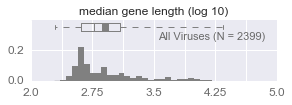

Enter file name: test


In [39]:
viruses = [np.log10(virus['median']*3) for virus in lengthData]
allViruses=[viruses]
hostNames= ['All Viruses']
colors=['grey']
numrow = 7
numcol = 3
histPlots(allViruses, hostNames, colors, numrow, numcol)

input_var = input("Enter file name: ")
filename = input_var+ '.txt'
fo = open(filename, 'w')
#writing the first line here, and the rest as part of the for loop 
fo.write('\t'+'Gene Length Statistics For Different Viral Groups'+'\n')
fo.write('\t'+ 'Min' +'\t'+ 'Max' + '\t'+ '25th Percentile'+'\t'+ 'Median'+ '\t' + '75th Percentile' 
         +'\t' + 'Mean' + '\t' +'Stdev.' +'\n')

for j in range(len(allViruses)):  
    #writing the stats to the file we started earlier 
    minimum ="%.1f" %min(np.power(10, allViruses[j]))
    maximum= "%.1f" %max(np.power(10, allViruses[j]))
    iqr1 = "%.1f" %np.percentile(np.power(10, allViruses[j]), 25, interpolation='lower')
    med ="%.1f" %np.median(np.power(10,allViruses[j]))
    iqr3 = "%.1f" %np.percentile(np.power(10, allViruses[j]), 75, interpolation='higher')
    avg ="%.1f" %np.mean(np.power(10,allViruses[j]))
    std ="%.1f" %np.std(np.power(10,allViruses[j]))
    
    fo.write(hostNames[j]+' (N = ' + str(len(allViruses[j])) + ')' +'\t'+ minimum +'\t'+ maximum + '\t'+ iqr1 +
             '\t'+ med+ '\t' + iqr3 + '\t' + avg +'\t'+ std + '\n')
    

fo.close()

###Plotting median gene lengths of dsDNA viral groups of eukaryotes
also writing key statistics to a text file


Enter file name: geneLengthEukdsDNA


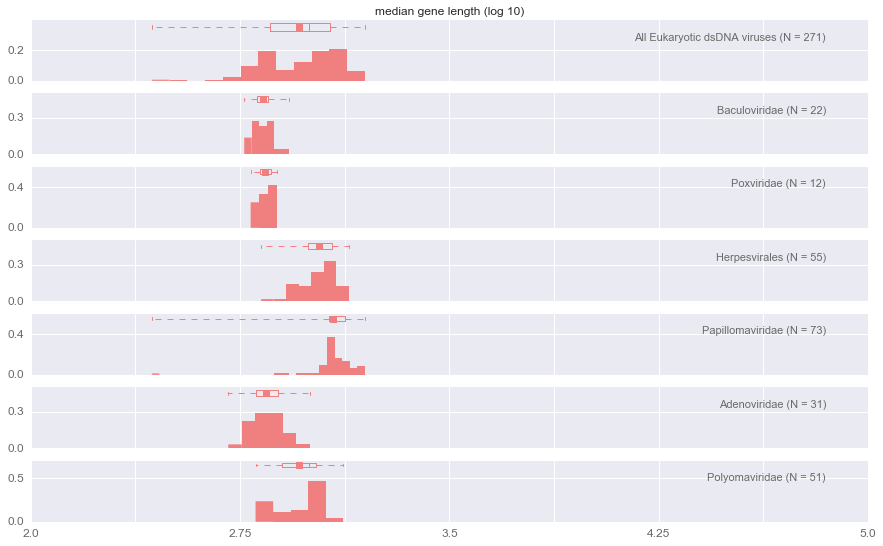

Enter file name: geneLengthEukdsDNA


In [24]:
virusesdsDNAEUKS = [np.log10(virus['median']*3) for virus in lengthData if 'dsDNA viruses, no RNA stage' 
                    in virus['englishLineage'] and 'Eukaryota' in virus['hostEnglishLineage']]
virusesBacu = [np.log10(virus['median']*3) for virus in lengthData if 'Baculoviridae' in virus['englishLineage']]
virusesPoxv = [np.log10(virus['median']*3) for virus in lengthData if 'Poxviridae' in virus['englishLineage']]
virusesHerp = [np.log10(virus['median']*3) for virus in lengthData if 'Herpesvirales' in virus['englishLineage']]
virusesPapi = [np.log10(virus['median']*3) for virus in lengthData if 'Papillomaviridae' in virus['englishLineage']]
virusesAden = [np.log10(virus['median']*3) for virus in lengthData if 'Adenoviridae' in virus['englishLineage']]
virusesPoly = [np.log10(virus['median']*3) for virus in lengthData if 'Polyomaviridae' in virus['englishLineage']]

#for testing the significance of gene length differences later (note, Not converting to log here)
dsDNAeuks = [virus['median']*3 for virus in lengthData if 'dsDNA viruses, no RNA stage' in virus['englishLineage']
             and 'Eukaryota' in virus['hostEnglishLineage']]


allViruses= [virusesdsDNAEUKS, virusesBacu,virusesPoxv,virusesHerp,virusesPapi,virusesAden,virusesPoly]
hostNames= ['All Eukaryotic dsDNA viruses', 'Baculoviridae', 'Poxviridae', 'Herpesvirales', 'Papillomaviridae',
            'Adenoviridae', 'Polyomaviridae']
colors=['lightcoral']*7
numrow = 7
numcol = 1
histPlots(allViruses, hostNames, colors, numrow, numcol)

input_var = input("Enter file name: ")
filename = input_var+ '.txt'
fo = open(filename, 'w')

#writing the first line here, and the rest as part of the for loop 
fo.write('\t'+'Median Gene Length Statistics For Different Viral Groups'+'\n')
fo.write('\t'+ 'Min' +'\t'+ 'Max' + '\t'+ '25th Percentile'+'\t'+ 'Median'+ '\t' + '75th Percentile' +'\t'
         + 'Mean' + '\t' +'Stdev.' +'\n')

for j in range(len(allViruses)):  
    #writing the stats to the file we started earlier 
    minimum ="%.1f" %min(np.power(10, allViruses[j]))
    maximum= "%.1f" %max(np.power(10, allViruses[j]))
    iqr1 = "%.1f" %np.percentile(np.power(10, allViruses[j]), 25, interpolation='lower')
    #note this would be median of medians
    med ="%.1f" %np.median(np.power(10,allViruses[j]))
    iqr3 = "%.1f" %np.percentile(np.power(10, allViruses[j]), 75, interpolation='higher')
    avg ="%.1f" %np.mean(np.power(10,allViruses[j]))
    std ="%.1f" %np.std(np.power(10,allViruses[j]))
    
    fo.write(hostNames[j]+' (N = ' + str(len(allViruses[j])) + ')' +'\t'+ minimum +'\t'+ maximum 
             + '\t'+ iqr1 + '\t'+ med+ '\t' + iqr3 + '\t' + avg +'\t'+ std + '\n')

fo.close()

###Plotting median gene lengths of dsDNA viral groups of bacteria
also writing key statistics to a text file


Enter file name: geneLengthBacdsDNA


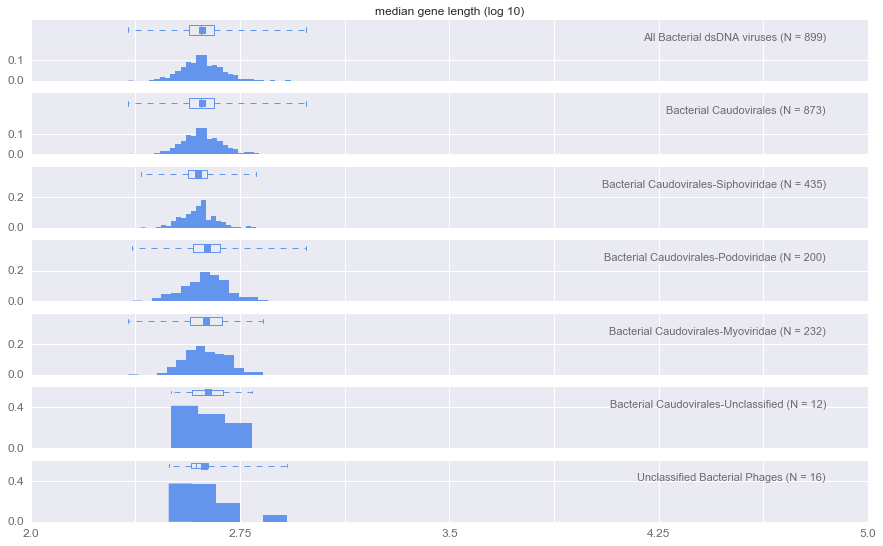

Enter file name: geneLengthBacdsDNA


In [31]:
virusesdsDNABACT = [np.log10(virus['median']*3) for virus in lengthData if 'dsDNA viruses, no RNA stage' 
                    in virus['englishLineage'] and 'Bacteria' in virus['hostEnglishLineage']]
virusesCaudo = [np.log10(virus['median']*3) for virus in lengthData if 'Caudovirales' in virus['englishLineage']
                and 'Bacteria' in virus['hostEnglishLineage']]
virusesSiph = [np.log10(virus['median']*3) for virus in lengthData if 'Caudovirales' in virus['englishLineage'] 
               and 'Siphoviridae' in virus['englishLineage']]
virusesPodo = [np.log10(virus['median']*3) for virus in lengthData if 'Caudovirales' in virus['englishLineage'] 
               and 'Podoviridae' in virus['englishLineage']]
virusesMyov = [np.log10(virus['median']*3) for virus in lengthData if 'Caudovirales' in virus['englishLineage'] 
               and 'Myoviridae' in virus['englishLineage']]
virusesCaudoUncl = [np.log10(virus['median']*3) for virus in lengthData if 'Caudovirales' in virus['englishLineage'] 
                    and 'unclassified Caudovirales' in virus['englishLineage']]
virusesUncl = [np.log10(virus['median']*3) for virus in lengthData if 'unclassified dsDNA phages' 
               in virus['englishLineage'] and 'Bacteria' in virus['hostEnglishLineage']]

#for testing the significance of median gene length differences later (note, Not converting to log)
dsDNAbact= [virus['median']*3 for virus in lengthData if 'dsDNA viruses, no RNA stage' in virus['englishLineage'] 
            and 'Bacteria' in virus['hostEnglishLineage']]


allViruses= [virusesdsDNABACT, virusesCaudo,virusesSiph,virusesPodo,virusesMyov, virusesCaudoUncl, virusesUncl]

hostNames= ['All Bacterial dsDNA viruses', 'Bacterial Caudovirales', 'Bacterial Caudovirales-Siphoviridae', 
            'Bacterial Caudovirales-Podoviridae', 'Bacterial Caudovirales-Myoviridae', 
            'Bacterial Caudovirales-Unclassified','Unclassified Bacterial Phages']
colors=['cornflowerblue']*7
numrow = 7
numcol = 1

histPlots(allViruses, hostNames, colors, numrow, numcol)

input_var = input("Enter file name: ")
filename = input_var+ '.txt'
fo = open(filename, 'w')
#writing the first line here, and the rest as part of the for loop 
fo.write('\t'+'Gene Length Statistics For Different Viral Groups'+'\n')
fo.write('\t'+ 'Min' +'\t'+ 'Max' + '\t'+ '25th Percentile'+'\t'+ 'Median'+ '\t' + '75th Percentile'
         +'\t' + 'Mean' + '\t' +'Stdev.' +'\n')

for j in range(len(allViruses)):  
    #writing the stats to the file we started earlier 
    minimum ="%.1f" %min(np.power(10, allViruses[j]))
    maximum= "%.1f" %max(np.power(10, allViruses[j]))
    iqr1 = "%.1f" %np.percentile(np.power(10, allViruses[j]), 25, interpolation='lower')
    med ="%.1f" %np.median(np.power(10,allViruses[j]))
    iqr3 = "%.1f" %np.percentile(np.power(10, allViruses[j]), 75, interpolation='higher')
    avg ="%.1f" %np.mean(np.power(10,allViruses[j]))
    std ="%.1f" %np.std(np.power(10,allViruses[j]))
    
    fo.write(hostNames[j]+' (N = ' + str(len(allViruses[j])) + ')' +'\t'+ minimum +'\t'+ maximum + 
             '\t'+ iqr1 + '\t'+ med+ '\t' + iqr3 + '\t' + avg +'\t'+ std + '\n')

fo.close()

###Plotting median gene lengths of dsDNA viral groups of archaea
also writing key statistics to a text file

Enter file name: geneLengthArcdsDNA


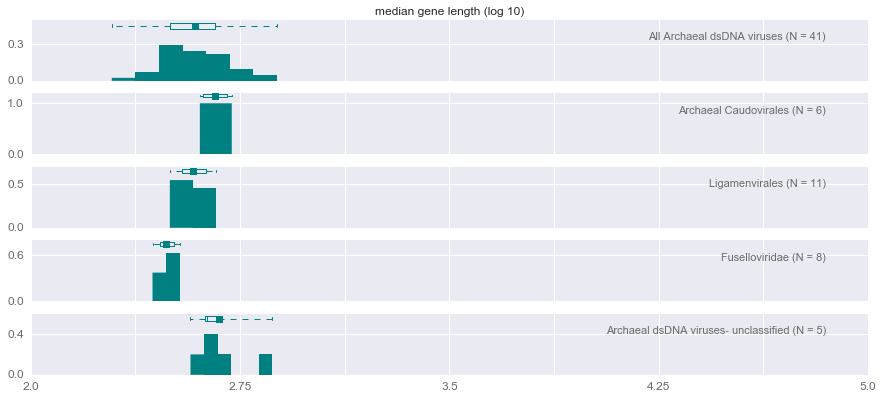

Enter file name: geneLengthArcdsDNA


In [28]:
#plotting median gene lengths of dsDNA viruses of archaea
virusesdsDNAArch = [np.log10(virus['median']*3) for virus in lengthData if 'dsDNA viruses, no RNA stage' 
                    in virus['englishLineage'] and 'Archaea' in virus['hostEnglishLineage']]
virusesCaudo = [np.log10(virus['median']*3) for virus in lengthData if 'Caudovirales'
                in virus['englishLineage'] and 'Archaea' in virus['hostEnglishLineage']]
virusesLiga = [np.log10(virus['median']*3) for virus in lengthData if 'Ligamenvirales' 
               in virus['englishLineage'] and 'Archaea' in virus['hostEnglishLineage']]
virusesFuse = [np.log10(virus['median']*3) for virus in lengthData if 'Fuselloviridae' 
               in virus['englishLineage'] and 'Archaea' in virus['hostEnglishLineage']]
virusesUncl = [np.log10(virus['median']*3) for virus in lengthData if 'unclassified dsDNA viruses'
               in virus['englishLineage'] and 'Archaea' in virus['hostEnglishLineage']]

#for testing the significance of gene length differences later (note, Not converting to log)
dsDNAarchs= [virus['median']*3 for virus in lengthData if 'dsDNA viruses, no RNA stage' 
             in virus['englishLineage'] and 'Archaea' in virus['hostEnglishLineage']]

allViruses= [virusesdsDNAArch, virusesCaudo,virusesLiga, virusesFuse, virusesUncl]

hostNames= ['All Archaeal dsDNA viruses', 'Archaeal Caudovirales', 'Ligamenvirales', 'Fuselloviridae', 
            'Archaeal dsDNA viruses- unclassified']
colors=['teal']*5
numrow = 7
numcol = 1

histPlots(allViruses, hostNames, colors, numrow, numcol)

input_var = input("Enter file name: ")
filename = input_var+ '.txt'
fo = open(filename, 'w')
#writing the first line here, and the rest as part of the for loop 
fo.write('\t'+'Gene Length Statistics For Different Viral Groups'+'\n')
fo.write('\t'+ 'Min' +'\t'+ 'Max' + '\t'+ '25th Percentile'+'\t'+ 'Median'+ '\t' + '75th Percentile' 
         +'\t' + 'Mean' + '\t' +'Stdev.' +'\n')

for j in range(len(allViruses)):  
    #writing the stats to the file we started earlier 
    minimum ="%.1f" %min(np.power(10, allViruses[j]))
    maximum= "%.1f" %max(np.power(10, allViruses[j]))
    iqr1 = "%.1f" %np.percentile(np.power(10, allViruses[j]), 25, interpolation='lower')
    med ="%.1f" %np.median(np.power(10,allViruses[j]))
    iqr3 = "%.1f" %np.percentile(np.power(10, allViruses[j]), 75, interpolation='higher')
    avg ="%.1f" %np.mean(np.power(10,allViruses[j]))
    std ="%.1f" %np.std(np.power(10,allViruses[j]))
    
    fo.write(hostNames[j]+' (N = ' + str(len(allViruses[j])) + ')' +'\t'+ minimum +'\t'+ maximum + '\t'+ 
             iqr1 + '\t'+ med+ '\t' + iqr3 + '\t' + avg +'\t'+ std + '\n')

fo.close()

###Plotting median gene lengths of ssDNA viral groups of eukaryotes
also writing key statistics to a text file

Enter file name: geneLengthEukssDNA


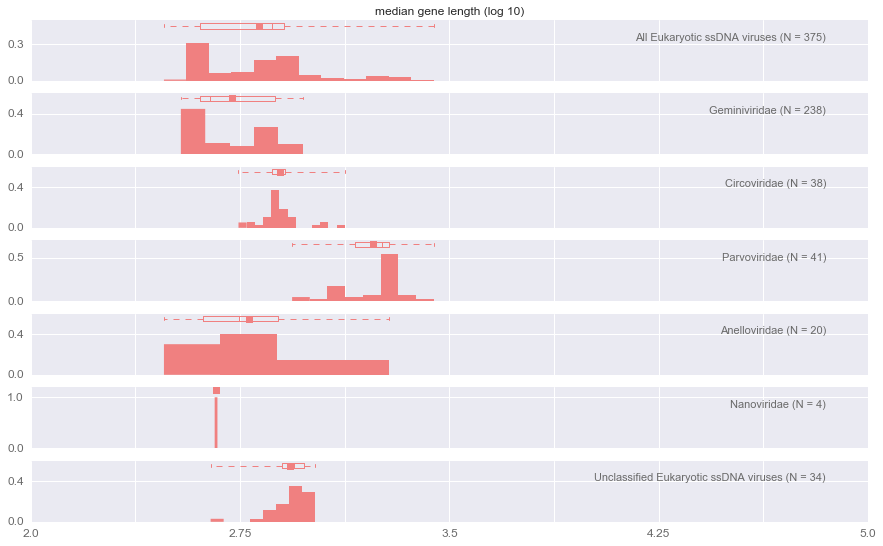

Enter file name: geneLengthEukssDNA


In [29]:
virusesssDNAEUKS = [np.log10(virus['median']*3) for virus in lengthData if 'ssDNA viruses' in virus['englishLineage'] 
                    and 'Eukaryota' in virus['hostEnglishLineage']]
virusesGemi = [np.log10(virus['median']*3) for virus in lengthData if 'Geminiviridae' in virus['englishLineage'] 
               and 'Eukaryota' in virus['hostEnglishLineage']]
virusesCirc = [np.log10(virus['median']*3) for virus in lengthData if 'Circoviridae' in virus['englishLineage'] 
               and 'Eukaryota' in virus['hostEnglishLineage']]
virusesParv = [np.log10(virus['median']*3) for virus in lengthData if 'Parvoviridae' in virus['englishLineage'] 
               and 'Eukaryota' in virus['hostEnglishLineage']]
virusesAnel = [np.log10(virus['median']*3) for virus in lengthData if 'Anelloviridae' in virus['englishLineage'] 
               and 'Eukaryota' in virus['hostEnglishLineage']]
virusesNano = [np.log10(virus['median']*3) for virus in lengthData if 'Nanoviridae' in virus['englishLineage'] 
               and 'Eukaryota' in virus['hostEnglishLineage']]
virusesUncl = [np.log10(virus['median']*3) for virus in lengthData if 'unclassified ssDNA viruses' in 
               virus['englishLineage'] and 'Eukaryota' in virus['hostEnglishLineage']]

#for statistical tests
ssDNAeuks= [virus['median']*3 for virus in lengthData if 'ssDNA viruses' in virus['englishLineage'] 
            and 'Eukaryota' in virus['hostEnglishLineage']]


allViruses= [virusesssDNAEUKS, virusesGemi,virusesCirc,virusesParv,virusesAnel,virusesNano,virusesUncl]
hostNames= ['All Eukaryotic ssDNA viruses', 'Geminiviridae', 'Circoviridae', 'Parvoviridae', 'Anelloviridae', 
            'Nanoviridae', 'Unclassified Eukaryotic ssDNA viruses']
colors=['lightcoral']*7
numrow = 7
numcol = 1
histPlots(allViruses, hostNames, colors, numrow, numcol)


input_var = input("Enter file name: ")
filename = input_var+ '.txt'
fo = open(filename, 'w')
#writing the first line here, and the rest as part of the for loop 
fo.write('\t'+'Gene Length Statistics For Different Viral Groups'+'\n')
fo.write('\t'+ 'Min' +'\t'+ 'Max' + '\t'+ '25th Percentile'+'\t'+ 'Median'+ '\t' + '75th Percentile' 
         +'\t' + 'Mean' + '\t' +'Stdev.' +'\n')

for j in range(len(allViruses)):  
    #writing the stats to the file we started earlier 
    minimum ="%.1f" %min(np.power(10, allViruses[j]))
    maximum= "%.1f" %max(np.power(10, allViruses[j]))
    iqr1 = "%.1f" %np.percentile(np.power(10, allViruses[j]), 25, interpolation='lower')
    med ="%.1f" %np.median(np.power(10,allViruses[j]))
    iqr3 = "%.1f" %np.percentile(np.power(10, allViruses[j]), 75, interpolation='higher')
    avg ="%.1f" %np.mean(np.power(10,allViruses[j]))
    std ="%.1f" %np.std(np.power(10,allViruses[j]))
    
    fo.write(hostNames[j]+' (N = ' + str(len(allViruses[j])) + ')' +'\t'+ minimum +'\t'+ maximum + 
             '\t'+ iqr1 + '\t'+ med+ '\t' + iqr3 + '\t' + avg +'\t'+ std + '\n')

fo.close()

###Plotting median gene lengths of ssDNA viral groups of bacteria
also writing key statistics to a text file

Enter file name: geneLengthBacssDNA


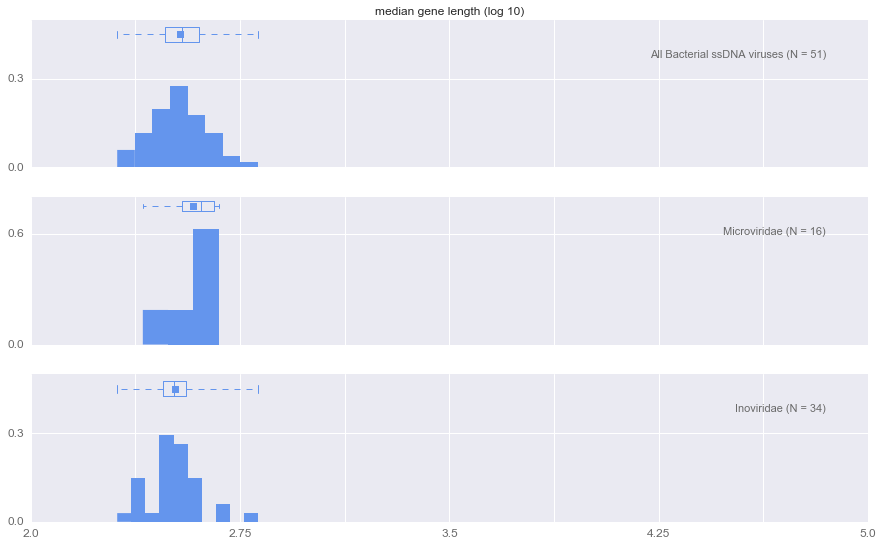

Enter file name: geneLengthBacssDNA


In [32]:
virusesssDNABact = [np.log10(virus['median']*3) for virus in lengthData if 'ssDNA viruses' in virus['englishLineage'] 
                    and 'Bacteria' in virus['hostEnglishLineage']]
virusesMicr = [np.log10(virus['median']*3) for virus in lengthData if 'Microviridae' in virus['englishLineage'] 
               and 'Bacteria' in virus['hostEnglishLineage']]
virusesInov = [np.log10(virus['median']*3) for virus in lengthData if 'Inoviridae' in virus['englishLineage'] 
               and 'Bacteria' in virus['hostEnglishLineage']]

#for statistical tests
ssDNAbact = [virus['median']*3 for virus in lengthData if 'ssDNA viruses' in virus['englishLineage'] 
             and 'Bacteria' in virus['hostEnglishLineage']]


allViruses= [virusesssDNABact, virusesMicr,virusesInov]
hostNames= ['All Bacterial ssDNA viruses', 'Microviridae', 'Inoviridae']
colors=['cornflowerblue']*3
numrow = 3
numcol = 1
histPlots(allViruses, hostNames, colors, numrow, numcol)

input_var = input("Enter file name: ")
filename = input_var+ '.txt'
fo = open(filename, 'w')
#writing the first line here, and the rest as part of the for loop 
fo.write('\t'+'Gene Length Statistics For Different Viral Groups'+'\n')
fo.write('\t'+ 'Min' +'\t'+ 'Max' + '\t'+ '25th Percentile'+'\t'+ 'Median'+ '\t' + '75th Percentile' 
         +'\t' + 'Mean' + '\t' +'Stdev.' +'\n')

for j in range(len(allViruses)):  
    #writing the stats to the file we started earlier 
    minimum ="%.1f" %min(np.power(10, allViruses[j]))
    maximum= "%.1f" %max(np.power(10, allViruses[j]))
    iqr1 = "%.1f" %np.percentile(np.power(10, allViruses[j]), 25, interpolation='lower')
    med ="%.1f" %np.median(np.power(10,allViruses[j]))
    iqr3 = "%.1f" %np.percentile(np.power(10, allViruses[j]), 75, interpolation='higher')
    avg ="%.1f" %np.mean(np.power(10,allViruses[j]))
    std ="%.1f" %np.std(np.power(10,allViruses[j]))
    
    fo.write(hostNames[j]+' (N = ' + str(len(allViruses[j])) + ')' +'\t'+ minimum +'\t'+ maximum + '\t'+ iqr1 
             + '\t'+ med+ '\t' + iqr3 + '\t' + avg +'\t'+ std + '\n')

fo.close()

###Testing the statistical significance of differences between various distributions


In [10]:
be = stats.mannwhitneyu(dsDNAeuks,dsDNAbact,  alternative='greater')
ba = stats.mannwhitneyu(dsDNAbact,dsDNAarchs,  alternative='greater')
ea = stats.mannwhitneyu(dsDNAeuks, dsDNAarchs,  alternative='greater')
print('H: euk dsDNA longer genes than bac dsDNA', be)
print('H: bac dsDNA longer genes than arc dsDNA', ba)
print('H: euk dsDNA longer genes than arc dsDNA', ea)
beSS = stats.mannwhitneyu(ssDNAeuks, ssDNAbact, alternative='greater')
print('H: euk ssDNA longer genes than bac ssDNA', beSS)
#For comparing DNA and RNA viruses. 
#Note, variables DNAviruses and RNAviruses was defined in the first script at the very top
rna = [virus['median']*3 for virus in RNAviruses]
dna = [virus['median']*3 for virus in DNAviruses]
dnarna = stats.mannwhitneyu(rna,dna, alternative='greater')
print('H: rna longer genes than DNA', dnarna)
#for comparing ssDNA and dsDNA viruses
ssdna = [virus['median']*3 for virus in DNAviruses if 'ssDNA viruses' in virus['englishLineage']]
dsdna = [virus['median']*3 for virus in DNAviruses if 'dsDNA viruses, no RNA stage' in virus['englishLineage']]
ssds = stats.mannwhitneyu(ssdna,dsdna, alternative='greater')
print('H: ssDNA longer genes than dsDNA', ssds)
bassds = stats.mannwhitneyu(dsDNAbact,ssDNAbact,  alternative='greater')
print('H: bac dsDNA longer genes bac ssDNA', bassds)
#for DNA RT group, however there are only 17 viruses in this category, didn't check significance


H: euk dsDNA longer genes than bac dsDNA MannwhitneyuResult(statistic=239279.0, pvalue=1.5303293274286952e-128)
H: bac dsDNA longer genes than arc dsDNA MannwhitneyuResult(statistic=21334.0, pvalue=0.043796303013729686)
H: euk dsDNA longer genes than arc dsDNA MannwhitneyuResult(statistic=10784.5, pvalue=1.3352344128891115e-22)
H: euk ssDNA longer genes than bac ssDNA MannwhitneyuResult(statistic=17357.0, pvalue=1.5943222688906145e-21)
H: rna longer genes than DNA MannwhitneyuResult(statistic=1119328.0, pvalue=9.3114709483938312e-241)
H: ssDNA longer genes than dsDNA MannwhitneyuResult(statistic=326200.5, pvalue=5.9732684154957127e-15)
H: bac dsDNA longer genes bac ssDNA MannwhitneyuResult(statistic=34042.0, pvalue=2.7311931875573335e-09)


###A function for plotting scatter plots

In [34]:
def scatterMaker(datax,datay, c):
    plt.scatter(datax, datay, color=c)
    plt.xlabel('Number of Genes', fontsize=12, color='dimgrey')
    plt.ylabel('Median Gene Length', fontsize=12, color='dimgrey')
    plt.xlim(0,300)
    plt.ylim(0,6000)
    plt.rcParams['pdf.fonttype'] = 42 

###Median gene length versus number of genes, Host Domain Classification 

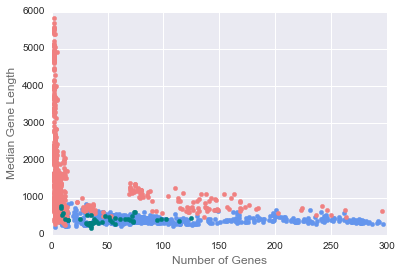

In [35]:
#note, numProteins is a count of the number of protein-coding genes. 
x = [virus['numProteins'] for virus in lengthData if 'Bacteria' in virus['hostEnglishLineage']]
y = [virus['numProteins'] for virus in lengthData if 'Eukaryota' in virus['hostEnglishLineage']]
z= [virus['numProteins'] for virus in lengthData if 'Archaea' in virus['hostEnglishLineage']]
#getting the median gene length
xx= [virus['median']*3 for virus in lengthData if 'Bacteria' in virus['hostEnglishLineage']]
yy=[virus['median']*3 for virus in lengthData if 'Eukaryota' in virus['hostEnglishLineage']]
zz=[virus['median']*3 for virus in lengthData if 'Archaea' in virus['hostEnglishLineage']]

#plotting the scatter plots
scatterMaker(x,xx,'cornflowerblue')
scatterMaker(y, yy,'lightcoral')
scatterMaker(z, zz,'teal')

plt.rcParams['pdf.fonttype'] = 42  
plt.savefig('hostDomain-GeneLengthVsNumGenes.pdf')


###Number of genes versus median gene length, Baltimore Classification 

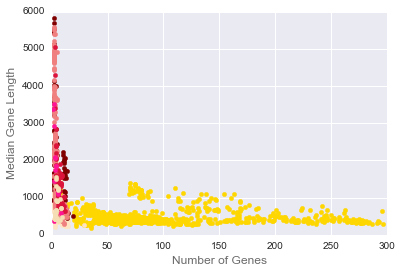

In [36]:
#Getting the gene/protein counts
x= [virus['numProteins'] for virus in lengthData if 'dsDNA viruses, no RNA stage' in virus['englishLineage']]
y= [virus['numProteins'] for virus in lengthData if 'ssDNA viruses' in virus['englishLineage']]
z= [virus['numProteins'] for virus in lengthData if 'dsRNA viruses' in virus['englishLineage']]
f= [virus['numProteins'] for virus in lengthData if 'ssRNA positive-strand viruses, no DNA stage' 
    in virus['englishLineage']]
j= [virus['numProteins'] for virus in lengthData if 'ssRNA negative-strand viruses' in virus['englishLineage']]
k= [virus['numProteins'] for virus in lengthData if 'Metaviridae' in virus['englishLineage'] or 'Retroviridae' 
    in virus['englishLineage']]
r= [virus['numProteins'] for virus in lengthData if 'Caulimoviridae' in virus['englishLineage'] or 'Hepadnaviridae'
    in virus['englishLineage']]

#getting the median gene lengths for each viral group
xx= [virus['median']*3 for virus in lengthData if 'dsDNA viruses, no RNA stage' in virus['englishLineage']]
yy= [virus['median']*3 for virus in lengthData if 'ssDNA viruses' in virus['englishLineage']]
zz= [virus['median']*3 for virus in lengthData if 'dsRNA viruses' in virus['englishLineage']]
ff= [virus['median']*3 for virus in lengthData if 'ssRNA positive-strand viruses, no DNA stage' 
     in virus['englishLineage']]
jj= [virus['median']*3 for virus in lengthData if 'ssRNA negative-strand viruses' in virus['englishLineage']]
kk= [virus['median']*3 for virus in lengthData if 'Metaviridae' in virus['englishLineage'] or 'Retroviridae'
     in virus['englishLineage']]
rr= [virus['median']*3 for virus in lengthData if 'Caulimoviridae' in virus['englishLineage'] or 'Hepadnaviridae'
     in virus['englishLineage']]

#plotting the scatter plots
scatterMaker(x,xx,'gold')
scatterMaker(y, yy,'bisque')
scatterMaker(z, zz,'maroon')
scatterMaker(f,ff,'lightcoral')
scatterMaker(j,jj,'crimson')
scatterMaker(k, kk,'deeppink')
scatterMaker(r, rr,'wheat')

plt.savefig('Baltimore-geneLengthVsNumGenes.pdf')


###Number of genes versus median gene length, Nucleotide Type Classification 

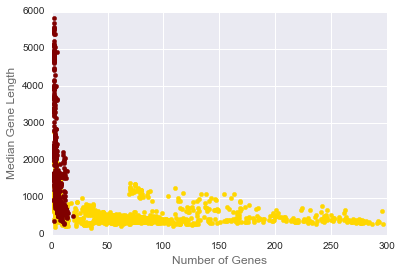

In [37]:
x= [virus['numProteins'] for virus in lengthData if 'dsDNA viruses, no RNA stage' in virus['englishLineage'] 
    or 'ssDNA viruses' in virus['englishLineage'] 
    or 'Caulimoviridae' in virus['englishLineage'] 
    or 'Hepadnaviridae' in virus['englishLineage']]
y= [virus['numProteins'] for virus in lengthData if 'dsRNA viruses' in virus['englishLineage'] 
    or 'ssRNA positive-strand viruses, no DNA stage' in virus['englishLineage'] 
    or 'ssRNA negative-strand viruses' in virus['englishLineage']
    or 'Metaviridae' in virus['englishLineage'] 
    or 'Retroviridae' in virus['englishLineage']]

xx= [virus['median']*3 for virus in lengthData if 'dsDNA viruses, no RNA stage' in virus['englishLineage'] 
    or 'ssDNA viruses' in virus['englishLineage'] 
    or 'Caulimoviridae' in virus['englishLineage'] 
    or 'Hepadnaviridae' in virus['englishLineage']]

yy= [virus['median']*3 for virus in lengthData if 'dsRNA viruses' in virus['englishLineage'] 
    or 'ssRNA positive-strand viruses, no DNA stage' in virus['englishLineage'] 
    or 'ssRNA negative-strand viruses' in virus['englishLineage']
    or 'Metaviridae' in virus['englishLineage'] 
    or 'Retroviridae' in virus['englishLineage']]

scatterMaker(x,xx,'gold')
scatterMaker(y, yy,'maroon')
plt.savefig('NT-geneLengthVsNumGenes.pdf')


###Number of genes versus median gene length, ICTV Classification 

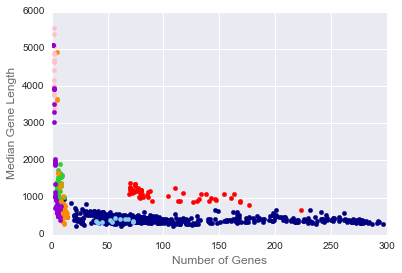

In [38]:
#number of proteins
x= [virus['numProteins'] for virus in lengthData if 'Caudovirales' in virus['englishLineage']]
y= [virus['numProteins'] for virus in lengthData if 'Herpesvirales' in virus['englishLineage']]
z= [virus['numProteins'] for virus in lengthData if 'Ligamenvirales' in virus['englishLineage']]
f= [virus['numProteins'] for virus in lengthData if 'Mononegavirales' in virus['englishLineage']]
j= [virus['numProteins'] for virus in lengthData if 'Nidovirales' in virus['englishLineage']]
k= [virus['numProteins'] for virus in lengthData if 'Picornavirales' in virus['englishLineage']]
r= [virus['numProteins'] for virus in lengthData if 'Tymovirales' in virus['englishLineage']]

#median protein lengths 
xx= [virus['median']*3 for virus in lengthData if 'Caudovirales' in virus['englishLineage']]
yy= [virus['median']*3 for virus in lengthData if 'Herpesvirales' in virus['englishLineage']]
zz= [virus['median']*3 for virus in lengthData if 'Ligamenvirales' in virus['englishLineage']]
ff= [virus['median']*3 for virus in lengthData if 'Mononegavirales' in virus['englishLineage']]
jj= [virus['median']*3 for virus in lengthData if 'Nidovirales' in virus['englishLineage']]
kk= [virus['median']*3 for virus in lengthData if 'Picornavirales' in virus['englishLineage']]
rr= [virus['median']*3 for virus in lengthData if 'Tymovirales' in virus['englishLineage']]

#plotting
scatterMaker(x,xx,'navy')
scatterMaker(y, yy,'r')
scatterMaker(z, zz,'skyblue')
scatterMaker(f,ff,'limegreen')
scatterMaker(j,jj,'darkorange')
scatterMaker(k, kk,'pink')
scatterMaker(r, rr,'darkviolet')
plt.savefig('ICTV-geneLengthVsNumGenes.pdf')
